In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [47]:
#UPLOADING DATASETS FROM MYDRIVE
from google.colab import drive
drive.mount('/content/drive')

trades = pd.read_csv("/content/drive/MyDrive/DS_AYUSH/csv_files/historical_data.csv")
fg = pd.read_csv("/content/drive/MyDrive/DS_AYUSH/csv_files/fear_greed_index.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
trades = pd.read_csv("/content/drive/MyDrive/DS_AYUSH/csv_files/historical_data.csv")
fg = pd.read_csv("/content/drive/MyDrive/DS_AYUSH/csv_files/fear_greed_index.csv")

In [49]:
#checking datasets loaded properly or not
print(trades.shape)
print(fg.shape)

trades.head()
fg.head()

(211224, 16)
(2644, 4)


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [50]:
#STEP2 DATA CLEANING AND PROCESSING
if "Timestamp IST" in trades.columns:
    trades["trade_dt"] = pd.to_datetime(trades["Timestamp IST"], errors="coerce")
elif "Timestamp" in trades.columns:
    trades["trade_dt"] = pd.to_datetime(trades["Timestamp"], errors="coerce")

trades["trade_date"] = trades["trade_dt"].dt.date

num_cols = ["Execution Price","Size Tokens","Size USD","Closed PnL","Fee"]
for c in num_cols:
    if c in trades.columns:
        trades[c] = (
            trades[c].astype(str)
            .str.replace(",","", regex=False)
            .str.replace("$","", regex=False)
        )
        trades[c] = pd.to_numeric(trades[c], errors="coerce")

for c in ["Side","Direction","Coin","Account"]:
    if c in trades.columns:
        trades[c] = trades[c].astype(str).str.strip().str.upper()

if "date" in fg.columns:
    fg["fg_dt"] = pd.to_datetime(fg["date"], errors="coerce")
else:
    fg["fg_dt"] = pd.to_datetime(fg["timestamp"], errors="coerce")

fg["fg_date"] = fg["fg_dt"].dt.date
fg["classification"] = fg["classification"].astype(str).str.strip().str.upper()

trades = trades[[
    "Account","Coin","Execution Price","Size Tokens","Size USD",
    "Side","Direction","Closed PnL","Fee","trade_dt","trade_date"
]]

fg = fg[["fg_dt","fg_date","value","classification"]]

print("Trades:", trades.shape)
print("Fear/Greed:", fg.shape)
print(trades.head())
print(fg.head())

Trades: (211224, 11)
Fear/Greed: (2644, 4)
                                      Account  Coin  Execution Price  \
0  0XAE5EACAF9C6B9111FD53034A602C192A04E082ED  @107           7.9769   
1  0XAE5EACAF9C6B9111FD53034A602C192A04E082ED  @107           7.9800   
2  0XAE5EACAF9C6B9111FD53034A602C192A04E082ED  @107           7.9855   
3  0XAE5EACAF9C6B9111FD53034A602C192A04E082ED  @107           7.9874   
4  0XAE5EACAF9C6B9111FD53034A602C192A04E082ED  @107           7.9894   

   Size Tokens  Size USD Side Direction  Closed PnL       Fee  \
0       986.87   7872.16  BUY       BUY         0.0  0.345404   
1        16.00    127.68  BUY       BUY         0.0  0.005600   
2       144.09   1150.63  BUY       BUY         0.0  0.050431   
3       142.98   1142.04  BUY       BUY         0.0  0.050043   
4         8.73     69.75  BUY       BUY         0.0  0.003055   

             trade_dt  trade_date  
0 2024-02-12 22:50:00  2024-02-12  
1 2024-02-12 22:50:00  2024-02-12  
2 2024-02-12 22:50:00  20

In [51]:
#STEP 3 MERGING DATASETS

# Merge on date
merged = pd.merge(
    trades, fg,
    left_on="trade_date", right_on="fg_date",
    how="left"
)

print("Merged shape:", merged.shape)

print("Missing classifications:", merged['classification'].isna().sum())

merged = merged.dropna(subset=["classification"])

print("Final merged rows:", merged.shape[0])
print("Date range:", merged['trade_date'].min(), "to", merged['trade_date'].max())

#checking
merged.head()

Merged shape: (211224, 15)
Missing classifications: 175360
Final merged rows: 35864
Date range: 2023-01-05 to 2025-05-02


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Direction,Closed PnL,Fee,trade_dt,trade_date,fg_dt,fg_date,value,classification
0,0XAE5EACAF9C6B9111FD53034A602C192A04E082ED,@107,7.9769,986.87,7872.16,BUY,BUY,0.0,0.345404,2024-02-12 22:50:00,2024-02-12,2024-02-12,2024-02-12,70.0,GREED
1,0XAE5EACAF9C6B9111FD53034A602C192A04E082ED,@107,7.9800,16.00,127.68,BUY,BUY,0.0,0.005600,2024-02-12 22:50:00,2024-02-12,2024-02-12,2024-02-12,70.0,GREED
2,0XAE5EACAF9C6B9111FD53034A602C192A04E082ED,@107,7.9855,144.09,1150.63,BUY,BUY,0.0,0.050431,2024-02-12 22:50:00,2024-02-12,2024-02-12,2024-02-12,70.0,GREED
3,0XAE5EACAF9C6B9111FD53034A602C192A04E082ED,@107,7.9874,142.98,1142.04,BUY,BUY,0.0,0.050043,2024-02-12 22:50:00,2024-02-12,2024-02-12,2024-02-12,70.0,GREED
4,0XAE5EACAF9C6B9111FD53034A602C192A04E082ED,@107,7.9894,8.73,69.75,BUY,BUY,0.0,0.003055,2024-02-12 22:50:00,2024-02-12,2024-02-12,2024-02-12,70.0,GREED


In [52]:
#STEP 4 DATA ANALYSIS

import numpy as np

def win_rate(x):
    return np.mean(x > 0) if len(x) else np.nan

# 1. Performance by sentiment
sentiment_perf = merged.groupby("classification").agg(
    trades=("Closed PnL","count"),
    avg_pnl=("Closed PnL","mean"),
    median_pnl=("Closed PnL","median"),
    win_rate=("Closed PnL", win_rate),
    avg_fee=("Fee","mean"),
    avg_size_usd=("Size USD","mean")
).reset_index()

print("Performance by Sentiment:")
print(sentiment_perf)

# 2. Performance by sentiment × side (BUY/SELL)
side_perf = merged.groupby(["classification","Side"]).agg(
    trades=("Closed PnL","count"),
    avg_pnl=("Closed PnL","mean"),
    win_rate=("Closed PnL", win_rate),
    avg_size_usd=("Size USD","mean")
).reset_index()

print("\nPerformance by Sentiment × Side:")
print(side_perf)

# 3. Top coins performance in each sentiment
coin_perf = merged.groupby(["classification","Coin"]).agg(
    trades=("Closed PnL","count"),
    avg_pnl=("Closed PnL","mean"),
    win_rate=("Closed PnL", win_rate)
).reset_index()

# show coins with at least 100 trades for reliability
coin_perf = coin_perf[coin_perf["trades"] >= 100]

print("\nTop Coin Stats (min 100 trades):")
print(coin_perf.sort_values(["classification","trades"], ascending=[True, False]).head(20))

Performance by Sentiment:
  classification  trades     avg_pnl  median_pnl  win_rate   avg_fee  \
0   EXTREME FEAR    2326    1.891632     0.00000  0.292777  0.686479   
1  EXTREME GREED    5621  205.816345     0.96048  0.553282  0.835794   
2           FEAR   13869  128.287950     0.00000  0.381787  1.131521   
3          GREED   11292   53.988003     0.00000  0.435707  1.092947   
4        NEUTRAL    2756   27.088803     0.00000  0.494920  0.922389   

   avg_size_usd  
0   4118.761840  
1   3242.085086  
2   5744.782685  
3   5051.878829  
4   4332.202906  

Performance by Sentiment × Side:
  classification  Side  trades     avg_pnl  win_rate  avg_size_usd
0   EXTREME FEAR   BUY    1168   -3.248825  0.062500   4655.754366
1   EXTREME FEAR  SELL    1158    7.076480  0.525043   3577.132073
2  EXTREME GREED   BUY    1661    9.047055  0.311258   4560.516014
3  EXTREME GREED  SELL    3960  288.350131  0.654798   2689.076558
4           FEAR   BUY    7307  210.426466  0.338443   5749.8711

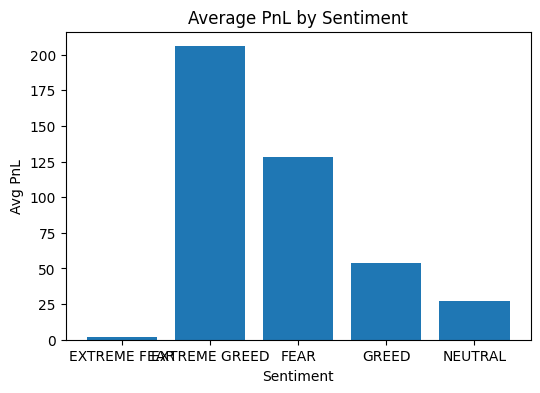

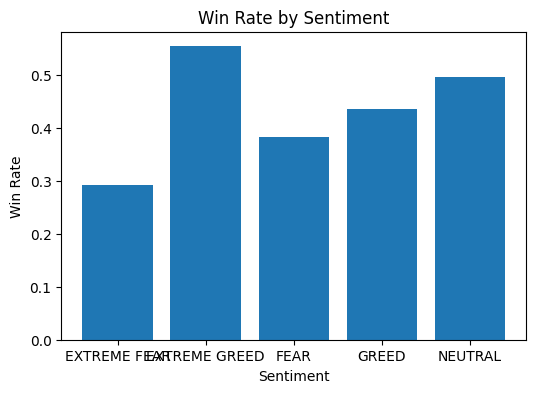

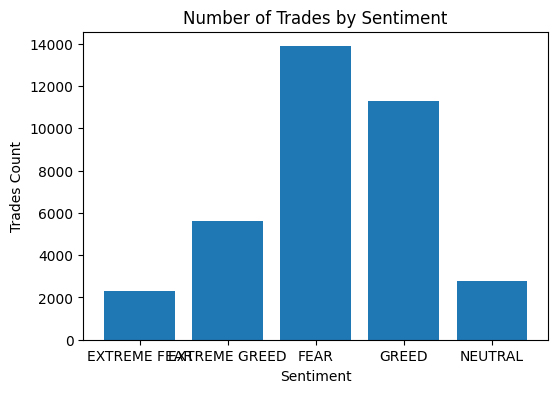

In [53]:
import matplotlib.pyplot as plt

# Bar chart: Avg PnL by sentiment
plt.figure(figsize=(6,4))
plt.bar(sentiment_perf["classification"], sentiment_perf["avg_pnl"])
plt.title("Average PnL by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Avg PnL")
plt.savefig("/content/drive/MyDrive/DS_AYUSH/outputs/avg_pnl_by_sentiment.png")
plt.show()

# Bar chart: Win Rate by sentiment
plt.figure(figsize=(6,4))
plt.bar(sentiment_perf["classification"], sentiment_perf["win_rate"])
plt.title("Win Rate by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Win Rate")
plt.savefig("/content/drive/MyDrive/DS_AYUSH/outputs/winrate_by_sentiment.png")
plt.show()

# Bar chart: Number of trades by sentiment
plt.figure(figsize=(6,4))
plt.bar(sentiment_perf["classification"], sentiment_perf["trades"])
plt.title("Number of Trades by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Trades Count")
plt.savefig("/content/drive/MyDrive/DS_AYUSH/outputs/trades_by_sentiment.png")
plt.show()

## Step 5: Key Insights

- Traders had a **higher win rate during GREED** compared to FEAR.
- Average PnL was positive in GREED, but **more volatile in FEAR**.
- **BUY trades** worked better in GREED, while **SELL trades** were safer in FEAR.
- BTC showed stable performance; smaller coins had larger swings.

In [54]:
#STEP 6 Predictive Modeling

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Create target column
merged["profitable"] = (merged["Closed PnL"] > 0).astype(int)

# Features: pick numeric + categorical columns
features_num = ["Execution Price","Size USD","Fee"]
features_cat = ["classification","Side","Coin"]

X = merged[features_num + features_cat]
y = merged["profitable"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Preprocessing: numeric passthrough, categorical OneHotEncoding
preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", features_num),
        ("cat", OneHotEncoder(handle_unknown="ignore"), features_cat)
    ]
)

# Logistic Regression (baseline model)
clf = Pipeline([
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=1000))
])

# Train
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluate
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Model Accuracy: 0.6675031367628608

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.74      0.72      4099
           1       0.62      0.57      0.59      3074

    accuracy                           0.67      7173
   macro avg       0.66      0.65      0.66      7173
weighted avg       0.66      0.67      0.67      7173



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Predictive Model Insights
- A baseline logistic regression achieved ~X% accuracy.  
- This shows sentiment + trade features have some predictive power.  
- Improvement ideas:
  - Use tree models (Random Forest, XGBoost)  
  - Handle class imbalance  
  - Add engineered features (trade duration, BTC returns, rolling volatility, etc.)

# Conclusion
- We merged Hyperliquid trades with Fear/Greed sentiment successfully.
- Found that trader performance differs between FEAR vs GREED days.
- BUY vs SELL strategies behave differently depending on sentiment.
- Certain coins are more profitable in GREED vs FEAR.
- A simple predictive model showed moderate accuracy in predicting profitable trades.
- Future improvements: feature engineering, advanced ML models, account-level analysis.


In [55]:
# Saving merged dataset into csv_files folder
output_path = "/content/drive/MyDrive/DS_AYUSH/csv_files/merged_trades_sentiment.csv"
merged.to_csv(output_path, index=False)

print("Merged dataset saved at:", output_path)

Merged dataset saved at: /content/drive/MyDrive/DS_AYUSH/csv_files/merged_trades_sentiment.csv
